In [1]:
import os 
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from utils import set_seed, Dataloader
from models import ViTEndToEnd

dir = os.getcwd()
print(f"Estas trabajando en el directorio: {dir}")

Estas trabajando en el directorio: /home/clincango/resnet_vit


In [2]:
dataloader = Dataloader(
    data_dir='/home/clincango/resnet_vit/Images',
    batch_size=16
)

dataloader.setup()

train_loader = dataloader.train_dataloader()
valid_loader = dataloader.val_dataloader()

In [3]:
# Sanity Check
subset = train_loader.dataset
print("Cantidad de imagenes en Train:", len(subset))
print("Ruta:", subset.dataset.samples[subset.indices[0]])


Cantidad de imagenes en Train: 558
Ruta: ('/home/clincango/resnet_vit/Images/Train_gray/C. Obsoletus/o (37)_flipv.png', 2)


In [4]:
subset_val = valid_loader.dataset
print("Cantidad de imagenes en Validacion:", len(subset_val))
print("Ruta:", subset_val.dataset.samples[subset_val.indices[0]])

Cantidad de imagenes en Validacion: 240
Ruta: ('/home/clincango/resnet_vit/Images/Train_gray/C. Pusillus/p (30)_rot90.png', 3)


In [5]:
total_images_train_gray = subset + subset_val
print('El total de muestras para entrenamiento y validacion es:', len(total_images_train_gray))

El total de muestras para entrenamiento y validacion es: 798


In [6]:
set_seed(42)
device = torch.device('cuda:5' if torch.cuda.is_available() else 'cpu')
Vit = ViTEndToEnd(pretrained=True, num_classes=4).to(device)

In [7]:
set_seed(42)

weights = torch.tensor([1.147, 0.723, 1.147, 1.147], dtype=torch.float).to(device) # weights -> 174, 276, 174, 174 samples -> C. foxi, C, insignis, C, obsoletus, C.pusillus

learning_rate = 1e-4
criterion = CrossEntropyLoss(weight=weights)
optimizer = Adam(Vit.parameters(), lr=learning_rate, weight_decay=1e-4, betas=(0.9, 0.999), eps=1e-08)

In [8]:
import torch
import torch
from torchmetrics.classification import (
    MulticlassAccuracy, MulticlassPrecision, MulticlassRecall,
    MulticlassF1Score, MulticlassMatthewsCorrCoef,
    MulticlassAUROC, MulticlassAveragePrecision
)

num_classes = 4

# métricas TRAIN
acc_tr  = MulticlassAccuracy(num_classes=num_classes, average='micro').to(device)
prec_tr = MulticlassPrecision(num_classes=num_classes, average='macro').to(device)
rec_tr  = MulticlassRecall(num_classes=num_classes, average='macro').to(device)
f1m_tr  = MulticlassF1Score(num_classes=num_classes, average='macro').to(device)
f1w_tr  = MulticlassF1Score(num_classes=num_classes, average='weighted').to(device)
mcc_tr  = MulticlassMatthewsCorrCoef(num_classes=num_classes).to(device)
roc_tr  = MulticlassAUROC(num_classes=num_classes, average='macro').to(device)
prc_tr  = MulticlassAveragePrecision(num_classes=num_classes, average='macro').to(device)

# métricas VAL
acc_va  = MulticlassAccuracy(num_classes=num_classes, average='micro').to(device)
prec_va = MulticlassPrecision(num_classes=num_classes, average='macro').to(device)
rec_va  = MulticlassRecall(num_classes=num_classes, average='macro').to(device)
f1m_va  = MulticlassF1Score(num_classes=num_classes, average='macro').to(device)
f1w_va  = MulticlassF1Score(num_classes=num_classes, average='weighted').to(device)
mcc_va  = MulticlassMatthewsCorrCoef(num_classes=num_classes).to(device)
roc_va  = MulticlassAUROC(num_classes=num_classes, average='macro').to(device)
prc_va  = MulticlassAveragePrecision(num_classes=num_classes, average='macro').to(device)

# --- historial ---
history = {
    "epoch": [],
    "train_loss": [],
    "val_loss": [],
    "train_f1w": [],
    "val_f1w": [],
}

best_f1w = 0.0
patience = 0
max_patience = 10
num_epochs = 100

for epoch in range(num_epochs):
    # ---------- TRAIN ----------
    Vit.train()
    train_loss = 0.0

    acc_tr.reset(); prec_tr.reset(); rec_tr.reset()
    f1m_tr.reset(); f1w_tr.reset(); mcc_tr.reset()
    roc_tr.reset(); prc_tr.reset()

    for X, y in train_loader:
        X = X.to(device); y = y.to(device, dtype=torch.long)
        optimizer.zero_grad(set_to_none=True)
        logits = Vit(X)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        with torch.no_grad():
            probs = torch.softmax(logits, dim=1)
            preds = probs.argmax(dim=1)
            acc_tr.update(preds, y);   prec_tr.update(preds, y);  rec_tr.update(preds, y)
            f1m_tr.update(preds, y);   f1w_tr.update(preds, y);   mcc_tr.update(preds, y)
            roc_tr.update(probs, y);   prc_tr.update(probs, y)

    n_tr = max(1, len(train_loader))
    tr_loss = train_loss / n_tr
    tr_acc   = acc_tr.compute().item() * 100
    tr_prec  = prec_tr.compute().item() * 100
    tr_rec   = rec_tr.compute().item() * 100
    tr_f1m   = f1m_tr.compute().item() * 100
    tr_f1w   = f1w_tr.compute().item() * 100
    tr_mcc   = mcc_tr.compute().item()
    tr_roc   = roc_tr.compute().item() * 100
    tr_prc   = prc_tr.compute().item() * 100

    # ---------- VALID ----------
    Vit.eval()
    val_loss = 0.0

    acc_va.reset(); prec_va.reset(); rec_va.reset()
    f1m_va.reset(); f1w_va.reset(); mcc_va.reset()
    roc_va.reset(); prc_va.reset()

    with torch.no_grad():
        for X, y in valid_loader:
            X = X.to(device); y = y.to(device, dtype=torch.long)
            logits = Vit(X)
            loss = criterion(logits, y)
            val_loss += loss.item()

            probs = torch.softmax(logits, dim=1)
            preds = probs.argmax(dim=1)
            acc_va.update(preds, y);   prec_va.update(preds, y);  rec_va.update(preds, y)
            f1m_va.update(preds, y);   f1w_va.update(preds, y);   mcc_va.update(preds, y)
            roc_va.update(probs, y);   prc_va.update(probs, y)

    n_va = max(1, len(valid_loader))
    va_loss = val_loss / n_va
    va_acc   = acc_va.compute().item() * 100
    va_prec  = prec_va.compute().item() * 100
    va_rec   = rec_va.compute().item() * 100
    va_f1m   = f1m_va.compute().item() * 100
    va_f1w   = f1w_va.compute().item() * 100
    va_mcc   = mcc_va.compute().item()
    va_roc   = roc_va.compute().item() * 100
    va_prc   = prc_va.compute().item() * 100

    # --- guardar al historial ---
    history["epoch"].append(epoch + 1)
    history["train_loss"].append(tr_loss)
    history["val_loss"].append(va_loss)
    history["train_f1w"].append(tr_f1w)
    history["val_f1w"].append(va_f1w)

    print(
        f"Epoch {epoch+1}/{num_epochs} | "
        f"train_loss={tr_loss:.4f} acc={tr_acc:.4f}% precM={tr_prec:.4f}% recM={tr_rec:.4f}% "
        f"F1M={tr_f1m:.4f}% F1W={tr_f1w:.4f}% MCC={tr_mcc:.4f} AUROC={tr_roc:.4f}% AUPRC={tr_prc:.4f}% || "
        f"val_loss={va_loss:.4f} acc={va_acc:.4f}% precM={va_prec:.4f}% recM={va_rec:.4f}% "
        f"F1M={va_f1m:.4f}% F1W={va_f1w:.4f}% MCC={va_mcc:.4f} AUROC={va_roc:.4f}% AUPRC={va_prc:.4f}%"
    )

    # ---------- Early stopping + checkpoint ----------
    if va_f1w > best_f1w:
        best_f1w = va_f1w
        patience = 0
        torch.save(Vit.state_dict(), "best_vit.pt")
    else:
        patience += 1
        if patience >= max_patience:
            print(f"Early stop at epoch {epoch+1}. Best val_f1w={best_f1w:.2f}%")
            break

Epoch 1/100 | train_loss=1.3044 acc=43.9338% precM=47.7369% recM=47.6685% F1M=44.0851% F1W=41.2591% MCC=0.2845 AUROC=72.2059% AUPRC=49.7293% || val_loss=1.1798 acc=66.6667% precM=72.9411% recM=73.0018% F1M=68.5943% F1W=64.8989% MCC=0.6004 AUROC=91.1931% AUPRC=77.6264%
Epoch 2/100 | train_loss=1.0679 acc=72.0588% precM=76.4796% recM=76.4844% F1M=74.0252% F1W=71.3986% MCC=0.6526 AUROC=92.0335% AUPRC=79.2863% || val_loss=0.9515 acc=71.2500% precM=80.1639% recM=78.1949% F1M=73.9457% F1W=69.8766% MCC=0.6710 AUROC=93.8330% AUPRC=84.0165%
Epoch 3/100 | train_loss=0.8581 acc=70.9559% precM=76.7876% recM=75.9850% F1M=72.5740% F1W=69.3550% MCC=0.6524 AUROC=93.5025% AUPRC=81.3987% || val_loss=0.7716 acc=76.6667% precM=81.2760% recM=81.3230% F1M=79.1511% F1W=76.7416% MCC=0.7104 AUROC=94.7142% AUPRC=86.6612%
Epoch 4/100 | train_loss=0.7136 acc=76.2868% precM=80.6803% recM=80.5489% F1M=78.3498% F1W=75.8562% MCC=0.7071 AUROC=94.3592% AUPRC=84.2015% || val_loss=0.6516 acc=77.0833% precM=82.7892% recM=

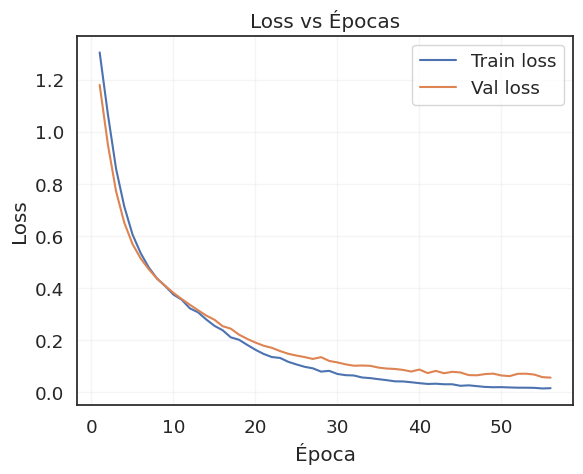

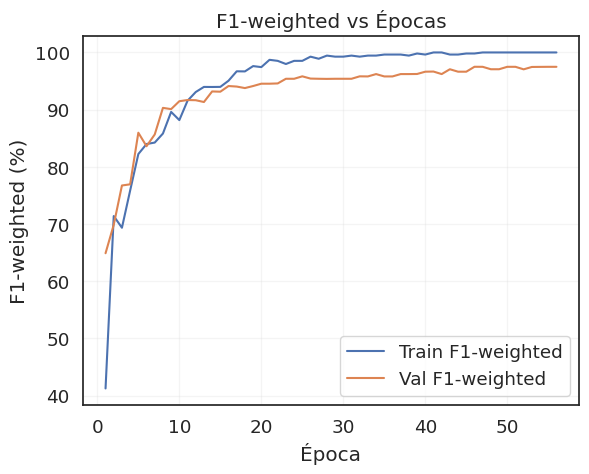

In [15]:
# Dataframe
df_hist = pd.DataFrame(history)
df_hist.to_csv("training_history.csv", index=False)

# Train / loss curves
plt.figure()
plt.plot(df_hist["epoch"], df_hist["train_loss"], label="Train loss")
plt.plot(df_hist["epoch"], df_hist["val_loss"], label="Val loss")
plt.xlabel("Época"); plt.ylabel("Loss"); plt.title("Loss vs Épocas"); plt.legend(); plt.grid(True, alpha=0.2)

plt.figure()
plt.plot(df_hist["epoch"], df_hist["train_f1w"], label="Train F1-weighted")
plt.plot(df_hist["epoch"], df_hist["val_f1w"], label="Val F1-weighted")
plt.xlabel("Época"); plt.ylabel("F1-weighted (%)"); plt.title("F1-weighted vs Épocas"); plt.legend(); plt.grid(True, alpha=0.2)

plt.show()